<a href="https://colab.research.google.com/github/GuilhermeAGouveia/ia-regression-and-classification-problems/blob/main/atividade_IA_3_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Atividade 3**

Equipe:


*   Caio Eduardo Marcondes
*   Guilherme Augusto Gouveia
*   Gustavo Morais Costa

**Introdução**

>Nesse problema, tentamos comparar difentes modelos de regressão e classificação a ponto de definir qual é melhor em determinados casos

**Conjunto de dados (Regressão):** https://www.kaggle.com/datasets/austinreese/craigslist-carstrucks-data

**Conjunto de dados (Classificação):** https://www.kaggle.com/datasets/rashikrahmanpritom/heart-attack-analysis-prediction-dataset

Importanto base de dados

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Código Principal

In [ ]:
from pandas.io.parquet import to_parquet
from numbers import Number
from enum import Enum
import math
from sklearn import preprocessing
import xgboost
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, BaseDecisionTree
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, \
    classification_report, mean_squared_error, r2_score
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from xgboost import XGBRegressor, XGBClassifier
import seaborn as sns
#Carregando módulo para ignorar mensagens de Warning
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

"""
@describe: Essa função fica responsável por normalizar dataframes inteiros em um dominio
"""
def encodding_strings(df: pd.DataFrame):
    le = preprocessing.LabelEncoder()
    for column in df:
        df[column] = le.fit_transform(df[column])
    return df

"""
@describe: Essa função é utilizada para converter um dicionário para um DataFrame, afim de obter uma visualização tabular dos dados
@param dict_: dicionário que será convertido para DataFrame
@return: DataFrame
"""
def convertDictToDataframe(dict_: dict):
  dataframe = pd.DataFrame()
  for i in dict_:
    dataframe[i] = dict_[i]
  return dataframe

"""
@describe: Enum utilizado para diferenciar os tipos de desbalanceamento, seu uso ficará mais claro adiante
"""
class Desbalance(Enum):
  MORE_POSITIVE = 0
  MORE_NEGATIVE = 1

"""
@class Problem: classe geral que define métodos em comum para problemas de Regressão e Classificação
"""
class Problem:
    def __init__(self, dataset_path):
        """
        @attr sets: Estrutura que irá organizar features e as saida desejadas que são para testes 
        """
        self.sets = {
            "features": {
                "test": [],
                "train": [],
            },
            "saidaDesejada": {
                "test": [],
                "train": [],
            }
        }
  
        self.dataset_path = dataset_path #caminho do conjunto de dedados 
        self.dataset = pd.DataFrame() #inicializando atributo que irá salvar o conjunto de dados

    #Este método possibilita a troca dinâmica de modelos de aprendizagem
    def set_model(self, model):
        self.model = model 

    #Este método irá tratar o dataset e definir o que é feature e o que é saida desejada, 
    #ao final o método prepare_train_and_test_sets é chamado 
    def mount_sets(self, saida_desejada_column, test_size=0.3, nivel_embaralhamento=None, tratamentFunc: lambda df: pd.DataFrame = None):
        pass

    #Este método carrega o conjunto de dados a partir do caminho dataset_path
    def load(self, n_instances=None):
        self.dataset = pd.read_csv(self.dataset_path, nrows=n_instances)

    #Defini os conjuntos de treino e teste e salva isso no atributo sets
    def prepare_train_and_test_sets(self, features, saida_desejada, nivel_embaralhamento, test_size):
        test_size = test_size / len(features)
        features_train, features_test, saidaDesejada_train, saidaDesejada_test = train_test_split(features,
                                                                                                  saida_desejada,
                                                                                                  test_size=test_size,
                                                                                                  random_state=nivel_embaralhamento)
        self.sets = {
            "features": {
                "train": features_train,
                "test": features_test
            },
            "saidaDesejada": {
                "train": saidaDesejada_train,
                "test": saidaDesejada_test
            }
        }

    #Este método cria uma divisão sequencial dos dados de treino, criando assim novos conjuntos de treino sem 
    #afetar o conjunto de teste
    def subdivide_train_set(self, n_sets = 5, sort_function = None):

      feature_train = self.sets['features']['train'].copy()
      saidaDesejada_train = self.sets['saidaDesejada']['train'].copy()
      #ordenando features e saidaDesejada de acordo com o tempo
      if sort_function:
        feature_train = sort_function(feature_train)
        saidaDesejada_train = sort_function(saidaDesejada_train)
      
      conjuntos_de_treino_subidivididos = []
      limit = math.trunc(len(feature_train) / n_sets) #diz quantos elementos terão cada novo conjunto após a subdivisão do conjunto de treino original
      for i in range (0, n_sets): #cada iteração deste for, retorna um novo conjunto de treino
        feature_temp = []
        saida_temp = []
        for j in range(0, limit): #este for defini quais serão os elementos de cada novo conjunto subdivido
          feature_temp.append(feature_train.iloc[i * limit + j])
          saida_temp.append(saidaDesejada_train.iloc[i * limit + j])
          
        conjuntos_de_treino_subidivididos.append({
            "features": {
                "train": pd.DataFrame(feature_temp)
            },
            "saidaDesejada": {
                "train": pd.DataFrame(saida_temp)
            }
        })

      return conjuntos_de_treino_subidivididos

    #Realiza o treinamento do modelo, se trainSet não for definido utiliza o conjunto de treino 
    #padrão self.sets['features']['train']
    def train(self, trainSet = None):
        print(f"\nModelo {self.model}")
        if not trainSet:
          trainSet = self.sets
        self.model.fit(trainSet['features']['train'], trainSet['saidaDesejada']['train'])

    #Realiza a predição de dados, se features não for definido utiliza o conjunto de treino 
    #padrão self.sets['features']['test']
    def predict(self, features=None):
        if not features:
            features = self.sets['features']['test']
        return self.model.predict(features)

    #Método abstrato para validação, cada tipo de problema (classificação e regressão) possui sua implementação
    def validation(self, saidaPrevista):
        pass
"""
@class RegressionProblem: Classe que defini um problema de regressão
"""
class RegressionProblem(Problem):

    def validation(self, predict_values, displayGraph = True):
        realValue = list(self.sets['saidaDesejada']['test'])
        rmse = np.sqrt(mean_squared_error(realValue, predict_values))
        r2 = r2_score(realValue, predict_values)
        print('Root Mean Squared Error: ', rmse)
        print('R2 Score: ', r2)

        if displayGraph:
          plt.figure(figsize=(17, 10))
          plt.rcParams.update({'font.size': 16})
          plt.plot(predict_values, color="blue", label="Previsões")
          plt.plot(realValue, color="red", label="Valores reais")
          plt.xlabel('Instâncias')
          plt.ylabel('Saída Desejada')
          plt.title(f"{self} - {self.model}", fontdict= {
              "fontsize": 18
          })
          plt.legend()
          plt.show()

    def __str__(self):
      return "Problema de Regressão"

    def mount_sets(self, saida_desejada_column, test_size=0.3, nivel_embaralhamento=None, tratamentFunc: lambda df: pd.DataFrame = None):
        if tratamentFunc:
          self.dataset = tratamentFunc(self.dataset)
        features = self.dataset
        features = features.drop(columns=[saida_desejada_column])
        features = encodding_strings(features)
        saida_desejada = self.dataset[saida_desejada_column]
        self.prepare_train_and_test_sets(features, saida_desejada, nivel_embaralhamento, test_size)

"""
@class RegressionProblem: Classe que define um problema de classificação
"""
class ClassifierProblem(Problem):

     #Método utilizado para causar um desbalancamento proposital em conjuntos de dados de classificação
    def desbalance_dataset(self, type_desbalance: Desbalance):
      if type_desbalance == Desbalance.MORE_POSITIVE:
        self.dataset = problem.dataset[:190]
      else:
        self.dataset = problem.dataset[130:]
      test_set_temp = {
          'saidaDesejada': self.sets['saidaDesejada']['test'],
          'features': self.sets['features']['test']
      }
      self.mount_sets(saida_desejada_column='output', test_size=20, nivel_embaralhamento=42)
      self.sets['saidaDesejada']['test'], self.sets['features']['test'] = test_set_temp['saidaDesejada'], test_set_temp['features']

    def __str__(self):
      return "Problema de Classificação"

    def mount_sets(self, saida_desejada_column, test_size=0.3, nivel_embaralhamento=None, tratamentFunc: lambda df: pd.DataFrame = None):
      if tratamentFunc:
        self.dataset = tratamentFunc(self.dataset)
      features = encodding_strings(self.dataset) #normalizando conjunto de dados
      features = features.drop(columns=[saida_desejada_column])
      saida_desejada = self.dataset[saida_desejada_column]
      self.prepare_train_and_test_sets(features, saida_desejada, nivel_embaralhamento, test_size)

    def validation(self, saidaPrevista):
      # Verificando o erro em relacao ao conjunto de testes
      saidaDesejada_test = self.sets['saidaDesejada']['test']
      accuracy_train = accuracy_score(saidaDesejada_test, saidaPrevista)
      recall_train = recall_score(saidaDesejada_test, saidaPrevista)
      precision_train = precision_score(saidaDesejada_test, saidaPrevista)
      f1_train = f1_score(saidaDesejada_test, saidaPrevista)
      print('------------------------------')
      print('------------------------------')
      print('Acurácia: ', accuracy_train)
      print('Recall: ', recall_train)
      print('Precision: ', precision_train)
      print('f1 Score: ', f1_train)
      print('------------------------------')
      print('------------------------------')
      print('--- Matriz de Confusão ---')
      display(pd.DataFrame(confusion_matrix(saidaDesejada_test, saidaPrevista),
                  index=['neg', 'pos'], columns=['pred_neg', 'pred_pos']))



# Regressão

Carregando problema de regressão

In [ ]:
problem = RegressionProblem(dataset_path="/content/drive/MyDrive/Dataset/vehicles_reverse.csv")
problem.load(n_instances=50_000)

len(problem.dataset)

50000

Cada problema tem um forma especifica de organizar seu conjunto de dados para que fique aplicável a modelos supervisionados, a função abaixo representa esse tratamento específico que cada problema de veículos deve ter

In [ ]:
def tratamentForVehiculosDataFrame(dataframe: pd.DataFrame):
    def remove_last_element_from_date(string):
      string = str(string)
      stringList = list(string.split('-'))
      stringList = stringList[:len(stringList) - 1]
      return '-'.join(stringList)

    dataframe = dataframe.drop(
            columns=['id', 'url','Unnamed: 0', 'region_url' , 'description', 'image_url', 'VIN', 'size', 'county']
            )
    dataframe['posting_date'] = dataframe['posting_date'].apply(remove_last_element_from_date)
    dataframe['posting_date'] = pd.to_datetime(dataframe['posting_date'] )
    dataframe = dataframe.set_index('posting_date')
    return dataframe

Criando conjuntos de dados para treino e teste



In [ ]:
problem.mount_sets(
    saida_desejada_column="price", 
    nivel_embaralhamento=42,
    tratamentFunc=tratamentForVehiculosDataFrame,
    test_size=100
    )

Apresentando conjunto de dados:

In [ ]:
problem.dataset.head(5)

,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,type,paint_color,state,lat,long
posting_date,,,,,,,,,,,,,,,,,
2021-04-04 03:21:07,wyoming,30590,2019.0,bmw,4 series 430i gran coupe,good,NaN,gas,22716.0,clean,other,rwd,coupe,NaN,wy,33.779214,-84.411811
2021-04-04 03:21:11,wyoming,28990,2018.0,lexus,es 350 sedan 4d,good,6 cylinders,gas,30112.0,clean,other,fwd,sedan,silver,wy,33.786500,-84.445400
2021-04-04 03:21:17,wyoming,34990,2020.0,cadillac,xt4 sport suv 4d,good,NaN,diesel,4174.0,clean,other,NaN,hatchback,white,wy,33.779214,-84.411811
2021-04-04 03:21:29,wyoming,30590,2020.0,volvo,s60 t5 momentum sedan 4d,good,NaN,gas,12029.0,clean,other,fwd,sedan,red,wy,33.786500,-84.445400
2021-04-04 03:21:31,wyoming,23590,2019.0,nissan,maxima s sedan 4d,good,6 cylinders,gas,32226.0,clean,other,fwd,sedan,NaN,wy,33.786500,-84.445400


## Verificar quais são as vantagens e desvantagens da utilização de diferentes modelos;


Definindo modelos de regressão

In [ ]:
dtr_model = DecisionTreeRegressor(min_samples_leaf=9)
knn_model = KNeighborsRegressor(n_neighbors=10)
randomf_model = RandomForestRegressor(n_estimators=20)
xgboost_model = XGBRegressor(n_estimators=1000)

Os paramêtros de cada um dos modelos foram definidos através de um método de força bruta, onde os valores são testados e o que retorna melhor resultado é selecionado



Definindo modelo a ser utilizado

In [ ]:
problem.set_model(randomf_model)



Aplicando modelo


Modelo RandomForestRegressor(n_estimators=20)
Root Mean Squared Error:  5502.008861957172
R2 Score:  0.9022449619364927


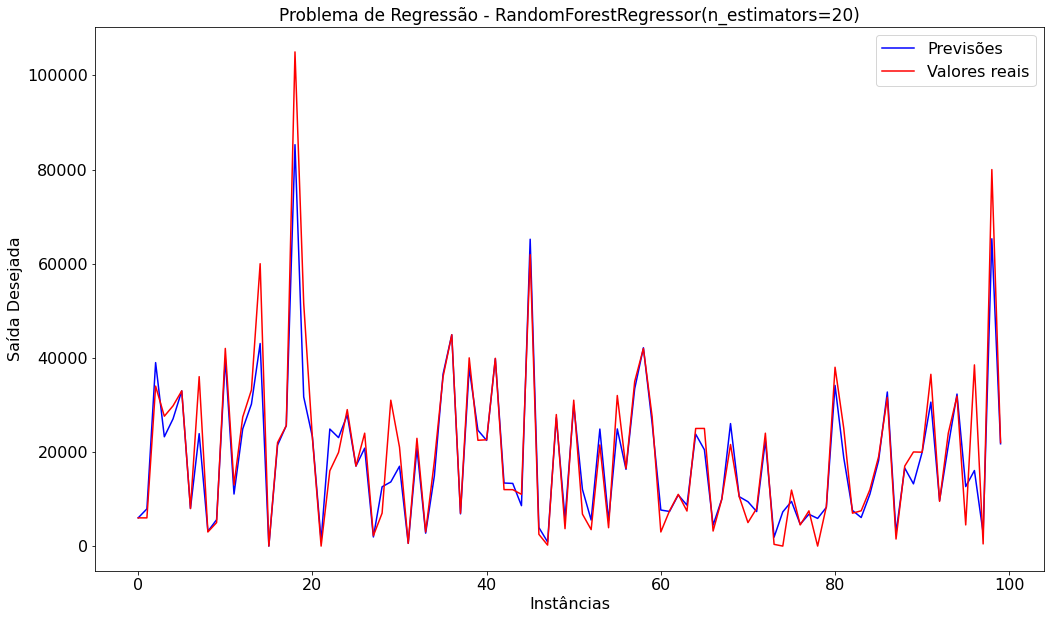

In [ ]:
problem.train()
predict_values = problem.predict()
problem.validation(predict_values)

### **Comparação entre modelos de regressão:**

>Conjunto de dados com 50_000 instâncias </br>
>Um numero de fixo de 100 instâncias é escolhido para testes

*   Random Forest
    * Root Mean Squared Error:  5186.44113346253
    * R2 Score:  0.9131368681103542


*   Decision Tree
    * Root Mean Squared Error:  7061.814009513637
    * R2 Score:  0.8389617181500788

*   KNN
    * Root Mean Squared Error:  14366.207297978824
    * R2 Score:  0.3335296462783567

*   XGBoost
    * Root Mean Squared Error:  6884.272270115412
    * R2 Score:  0.8469572875301563



## Verificar o impacto de diferentes conjuntos de treinamento sobre o desempenho do modelo (o conjunto de teste deve ser fixo)

Subdivindo o conjunto de treino original em conjuntos de treinos menores

In [ ]:
#funcao lambda para ordenar dataframe em ordem descrencente de acordo com index, no caso o indice é uma data
sort_index_date_desc = lambda df: df.sort_index(ascending=False)

"""
@var nSets: numero de conjuntos de treinos que quero criar
@var conjuntos_train: Essa variavel é um vetor com nSets posições e armazena conjuntos de treinos subdividos a partir de conjunto de treino principal
"""
n_sets = 4
conjuntos_train = problem.subdivide_train_set(n_sets=n_sets, sort_function=sort_index_date_desc) 

Conjunto com os dados mais recentes

In [ ]:
conjuntos_train[0]['features']['train'].head(3)

,region,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,type,paint_color,state,lat,long
2021-05-04 23:59:45,25,96,7,6459,0,6,2,3652,1,0,0,10,10,6,2799,5012
2021-05-04 23:24:09,24,85,13,3664,0,6,2,17274,0,0,0,10,10,5,3368,4383
2021-05-04 23:12:08,14,85,13,3666,0,6,2,17359,0,0,0,8,10,5,3369,4397


Conjunto de dados mais antigo

In [ ]:
conjuntos_train[n_sets - 1]['features']['train'].tail(5)

,region,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,type,paint_color,state,lat,long
2021-04-04 03:20:50,35,91,16,2258,2,3,2,7432,0,0,1,13,9,2,2093,5807
2021-04-04 03:08:37,35,89,41,1021,6,8,2,5529,0,0,3,13,12,2,1266,4843
2021-04-04 02:03:15,14,91,10,2696,0,3,2,9463,6,0,3,9,12,5,3267,4659
NaT,1,101,41,7844,6,8,5,21866,6,3,3,13,12,4,6765,6699
NaT,43,101,41,7844,6,8,5,21866,6,3,3,13,12,4,6765,6699


O conjunto está ordenado em ordem cronológica inversa, onde o primeiro elemento do conjunto de treino é o mais recente, logo o conjunto conjuntos_train[ 0 ] contém os dados mais recentes, e o conjuntos_train[ nSets - 1 ] contém os dados mais antigos.

Treinando modelo utilizando cada conjunto de treino:

conjunto_train[ 0 ], conjunto_train[ 1 ], ..., conjunto_train[ nSets - 1 ]

In [ ]:
problem.set_model(dtr_model)

for i in range(0, n_sets):
  problem.train(conjuntos_train[i])

  predict_values = problem.predict()
  problem.validation(predict_values, displayGraph=False)



Modelo DecisionTreeRegressor(min_samples_leaf=9)
Root Mean Squared Error:  9347.497339849338
R2 Score:  0.7178453067842464

Modelo DecisionTreeRegressor(min_samples_leaf=9)
Root Mean Squared Error:  11374.456736539534
R2 Score:  0.5822101311558896

Modelo DecisionTreeRegressor(min_samples_leaf=9)
Root Mean Squared Error:  10943.411819219893
R2 Score:  0.6132751643427253

Modelo DecisionTreeRegressor(min_samples_leaf=9)
Root Mean Squared Error:  12012.982609230594
R2 Score:  0.533986739551096


É perceptivel que o conjunto de treino que contém os dados mais recentes apresenta valores melhores com relação as métricas de validação, enquanto que o conjunto de dados mais antigo possui as piores taxas.

# Classificação

Carregando conjunto de dados

In [ ]:
problem = ClassifierProblem(dataset_path="/content/drive/MyDrive/Dataset/heart.csv")
problem.load()

len(problem.dataset)

303

Visualizando o conjunto de dados

In [ ]:
problem.dataset.head(5)

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


Dividindo o conjunto de dados e definindo conjuntos de treino e teste

In [ ]:
problem.mount_sets(saida_desejada_column='output', test_size=30, nivel_embaralhamento=42)
len(problem.sets['features']['train'])

273

Definindo modelos de classificação

In [ ]:
knn_model = KNeighborsClassifier(n_neighbors=9, metric='euclidean')
dst_model = DecisionTreeClassifier(min_samples_leaf=8)
randomf_model = RandomForestClassifier(n_estimators=9)
xgboost_model = XGBClassifier(n_estimators=2)

## Verificar quais são as vantagens e desvantagens da utilização de diferentes modelos;


Definindo modelo a ser usado no momento

In [ ]:
problem.set_model(knn_model)

Realizando treino e previsões

In [ ]:
problem.train()
predict_values = problem.predict()
problem.validation(predict_values)


Modelo KNeighborsClassifier(metric='euclidean', n_neighbors=9)
------------------------------
------------------------------
Acurácia:  0.8333333333333334
Recall:  0.875
Precision:  0.8235294117647058
f1 Score:  0.8484848484848485
------------------------------
------------------------------
--- Matriz de Confusão ---


,pred_neg,pred_pos
neg,11,3
pos,2,14


### **Comparação entre modelos de Classificação:**

>Conjunto de dados com 303 instâncias </br>
>Um numero de fixo de 30 instâncias é escolhido para testes

*   Random Forest
    * Acurácia:  0.7666666666666667
    * Recall:    0.75
    * Precision: 0.8
    * f1 Score:  0.7741935483870969


*   Decision Tree (**Melhor**)
    * Acurácia:  0.9333333333333333
    * Recall:  0.9375
    * Precision:  0.9375
    * f1 Score:  0.9375

*   KNN
    * Acurácia:  0.8333333333333334
    * Recall:  0.875
    * Precision:  0.8235294117647058
    * f1 Score:  0.8484848484848485

*   XGBoost
    * Acurácia:  0.8333333333333334
    * Recall:  0.9375
    * Precision:  0.7894736842105263
    * f1 Score:  0.8571428571428572 

### Formulas das métricas usadas

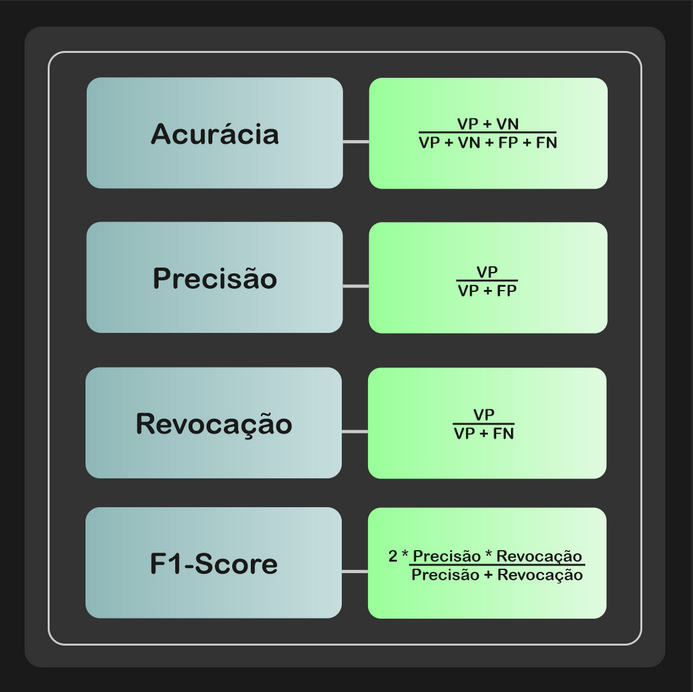

## Entender como o balanceamento dos dados pode influenciar o aprendizado (só em problemas de classificação);

Demonstrando que o conjunto de dados está balanceado

Chance baixa :  138
Chance alta :  165
---------------------
Proporção dos que tem chance baixa:  45.54455445544554
Proporção dos que tem chance alta:  54.45544554455446


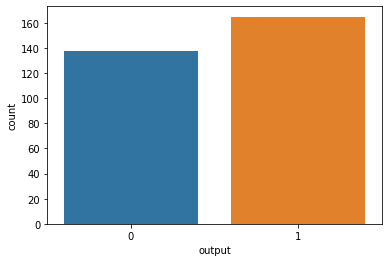

In [ ]:
# Identificacao grafica da distribuicao das instancias
sns.countplot(problem.dataset['output'],label="Count")

chance_alta, chance_baixa = problem.dataset['output'].value_counts()
print('Chance baixa : ',chance_baixa)
print('Chance alta : ',chance_alta)
print('---------------------')
print('Proporção dos que tem chance baixa: ', 100*chance_baixa/(chance_baixa+chance_alta))
print('Proporção dos que tem chance alta: ', 100*chance_alta/(chance_baixa+chance_alta))

### Conjunto desbalanceado (mais positivo)

Com uso do método desbalance_dataset, causamos um desbalancemento proposital no conjunto de dados, sem alterar o conjunto de testes

In [ ]:
problem.desbalance_dataset(type_desbalance=Desbalance.MORE_POSITIVE)

Provando o desbalanceamento

Chance baixa :  25
Chance alta :  165
---------------------
Proporção dos que tem chance baixa:  13.157894736842104
Proporção dos que tem chance alta:  86.84210526315789


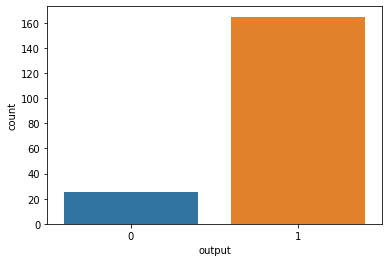

In [ ]:
sns.countplot(problem.dataset['output'],label="Count")

chance_alta, chance_baixa = problem.dataset['output'].value_counts()
print('Chance baixa : ',chance_baixa)
print('Chance alta : ',chance_alta)
print('---------------------')
print('Proporção dos que tem chance baixa: ', 100*chance_baixa/(chance_baixa+chance_alta))
print('Proporção dos que tem chance alta: ', 100*chance_alta/(chance_baixa+chance_alta))

Utilizando um modelo como exemplo para verificar os impactos de um conjunto desbalanceado

In [ ]:
problem.set_model(knn_model)

problem.train()
predict_values = problem.predict()
problem.validation(predict_values)


Modelo KNeighborsClassifier(metric='euclidean', n_neighbors=9)
------------------------------
------------------------------
Acurácia:  0.5333333333333333
Recall:  1.0
Precision:  0.5333333333333333
f1 Score:  0.6956521739130436
------------------------------
------------------------------
--- Matriz de Confusão ---


,pred_neg,pred_pos
neg,0,14
pos,0,16


Como o conjunto de dados tem mais instâncias de treinamento para quando uma pessoa tem alta chances de um ataque cardiaco, quando ele encontra uma pessoa que tem baixa chance ele não consegue determinar com precisão se a pessoa realmente tem baixa chance de um ataque cardiaco, isso ocorre porquê o conjunto de treinamento não tem muitas referências para quando pessoas tem baixa chance dentro de seu conjunto de treino

### Conjunto desbalanceado (mais negativo)

Provando o desbalanceamento

In [ ]:
problem.desbalance_dataset(type_desbalance=Desbalance.MORE_NEGATIVE)

Chance baixa :  35
Chance alta :  138
---------------------
Proporção dos que tem chance baixa:  20.23121387283237
Proporção dos que tem chance alta:  79.76878612716763


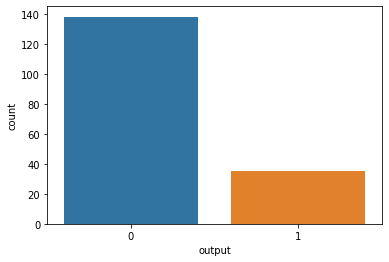

In [ ]:
sns.countplot(problem.dataset['output'],label="Count")

chance_alta, chance_baixa = problem.dataset['output'].value_counts()
print('Chance baixa : ',chance_baixa)
print('Chance alta : ',chance_alta)
print('---------------------')
print('Proporção dos que tem chance baixa: ', 100*chance_baixa/(chance_baixa+chance_alta))
print('Proporção dos que tem chance alta: ', 100*chance_alta/(chance_baixa+chance_alta))

Utilizando um modelo como exemplo para verificar os impactos de um conjunto desbalanceado

In [ ]:
problem.set_model(knn_model)

problem.train()
predict_values = problem.predict()
problem.validation(predict_values)


Modelo KNeighborsClassifier(metric='euclidean', n_neighbors=9)
------------------------------
------------------------------
Acurácia:  0.5333333333333333
Recall:  0.125
Precision:  1.0
f1 Score:  0.2222222222222222
------------------------------
------------------------------
--- Matriz de Confusão ---


,pred_neg,pred_pos
neg,14,0
pos,14,2


## Verificar o impacto de diferentes conjuntos de treinamento sobre o desempenho do modelo (o conjunto de teste deve ser fixo)

In [ ]:
"""
@var nSets: numero de conjuntos de treinos que quero criar
@var conjuntos_train: Essa variavel é um vetor com nSets posições e armazena conjuntos de treinos subdividos a partir de conjunto de treino principal
"""
nSets = 2
conjuntos_train = problem.subdivide_train_set(n_sets=nSets) 
conjuntos_train[0]['features']['train'].head()

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall
139,30,1,0,20,92,0,1,8,1,2,1,1,3
284,27,1,0,28,38,0,0,37,1,18,2,1,3
198,28,1,0,14,96,0,1,6,1,17,1,2,3
42,11,1,0,4,39,0,0,47,1,28,1,0,2
17,32,0,3,34,57,0,1,15,0,25,0,0,2


###Random Forest

In [ ]:
problem.set_model(randomf_model)

for i in range(0, nSets):
  problem.train(conjuntos_train[i])

  predict_values = problem.predict()
  problem.validation(predict_values)


Modelo RandomForestClassifier(n_estimators=9)
------------------------------
------------------------------
Acurácia:  0.8
Recall:  0.75
Precision:  0.8571428571428571
f1 Score:  0.7999999999999999
------------------------------
------------------------------
--- Matriz de Confusão ---


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


,pred_neg,pred_pos
neg,12,2
pos,4,12



Modelo RandomForestClassifier(n_estimators=9)
------------------------------
------------------------------
Acurácia:  0.8333333333333334
Recall:  0.8125
Precision:  0.8666666666666667
f1 Score:  0.8387096774193549
------------------------------
------------------------------
--- Matriz de Confusão ---


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


,pred_neg,pred_pos
neg,12,2
pos,3,13


###   Decision Tree

In [ ]:
problem.set_model(dst_model)

for i in range(0, nSets):
  problem.train(conjuntos_train[i])

  predict_values = problem.predict()
  problem.validation(predict_values)


Modelo DecisionTreeClassifier(min_samples_leaf=8)
------------------------------
------------------------------
Acurácia:  0.8333333333333334
Recall:  0.8125
Precision:  0.8666666666666667
f1 Score:  0.8387096774193549
------------------------------
------------------------------
--- Matriz de Confusão ---


,pred_neg,pred_pos
neg,12,2
pos,3,13



Modelo DecisionTreeClassifier(min_samples_leaf=8)
------------------------------
------------------------------
Acurácia:  0.7666666666666667
Recall:  0.6875
Precision:  0.8461538461538461
f1 Score:  0.7586206896551724
------------------------------
------------------------------
--- Matriz de Confusão ---


,pred_neg,pred_pos
neg,12,2
pos,5,11


###KNN

In [ ]:
problem.set_model(knn_model)

for i in range(0, nSets):
  problem.train(conjuntos_train[i])

  predict_values = problem.predict()
  problem.validation(predict_values)


Modelo KNeighborsClassifier(metric='euclidean', n_neighbors=9)
------------------------------
------------------------------
Acurácia:  0.8
Recall:  0.8125
Precision:  0.8125
f1 Score:  0.8125
------------------------------
------------------------------
--- Matriz de Confusão ---


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


,pred_neg,pred_pos
neg,11,3
pos,3,13



Modelo KNeighborsClassifier(metric='euclidean', n_neighbors=9)
------------------------------
------------------------------
Acurácia:  0.7666666666666667
Recall:  0.875
Precision:  0.7368421052631579
f1 Score:  0.7999999999999999
------------------------------
------------------------------
--- Matriz de Confusão ---


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


,pred_neg,pred_pos
neg,9,5
pos,2,14


###XGBoost

In [ ]:
problem.set_model(xgboost_model)
for i in range(0, nSets):
  problem.train(conjuntos_train[i])

  predict_values = problem.predict()
  problem.validation(predict_values)


Modelo XGBClassifier(n_estimators=2)


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


------------------------------
------------------------------
Acurácia:  0.7666666666666667
Recall:  0.8125
Precision:  0.7647058823529411
f1 Score:  0.787878787878788
------------------------------
------------------------------
--- Matriz de Confusão ---


,pred_neg,pred_pos
neg,10,4
pos,3,13



Modelo XGBClassifier(n_estimators=2)
------------------------------
------------------------------
Acurácia:  0.8
Recall:  0.8125
Precision:  0.8125
f1 Score:  0.8125
------------------------------
------------------------------
--- Matriz de Confusão ---


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


,pred_neg,pred_pos
neg,11,3
pos,3,13


# Códigos definidos para testes e validação do conjunto de dados

Teste de força bruta para pegar os melhores parametros para cada modelo

In [ ]:
max = 0
value = 0
for i in range( 1, 10):
  #knn_model = DecisionTreeClassifier(min_samples_leaf=i)
  XGBModel = XGBClassifier(n_estimators=i)
  problem.set_model(XGBModel)
  problem.train()
  print(f"treino {i}")
  predict_values = problem.predict()
  r2 = accuracy_score(list(problem.sets['saidaDesejada']['test']), predict_values)
  if r2 > max: 
    value = i
    max = r2

print(value, max)


Modelo XGBClassifier(n_estimators=1)
treino 1

Modelo XGBClassifier(n_estimators=2)
treino 2

Modelo XGBClassifier(n_estimators=3)
treino 3

Modelo XGBClassifier(n_estimators=4)
treino 4

Modelo XGBClassifier(n_estimators=5)
treino 5

Modelo XGBClassifier(n_estimators=6)
treino 6

Modelo XGBClassifier(n_estimators=7)
treino 7

Modelo XGBClassifier(n_estimators=8)
treino 8

Modelo XGBClassifier(n_estimators=9)
treino 9

Modelo XGBClassifier(n_estimators=10)
treino 10

Modelo XGBClassifier(n_estimators=11)
treino 11

Modelo XGBClassifier(n_estimators=12)
treino 12

Modelo XGBClassifier(n_estimators=13)
treino 13

Modelo XGBClassifier(n_estimators=14)
treino 14

Modelo XGBClassifier(n_estimators=15)
treino 15

Modelo XGBClassifier(n_estimators=16)
treino 16

Modelo XGBClassifier(n_estimators=17)
treino 17

Modelo XGBClassifier(n_estimators=18)
treino 18

Modelo XGBClassifier(n_estimators=19)
treino 19

Modelo XGBClassifier(n_estimators=20)
treino 20

Modelo XGBClassifier(n_estimators=21)

In [ ]:
knnModel = KNeighborsClassifier(n_neighbors=10, metric='euclidean')

dadosEntrada_train = problem.sets['features']['train']
dadosEntrada_test = problem.sets['features']['test']

saidaDesejada_train = problem.sets['saidaDesejada']['train']
saidaDesejada_test = problem.sets['saidaDesejada']['test']

# Ajustando o modelo K-NN com os dados de treino
knnModel.fit(dadosEntrada_train, saidaDesejada_train)

# Calculando a saida para o arquivo de treinamento (classificando os dados de treino)
saidaPrevista_test = knnModel.predict(dadosEntrada_test)

# Verificando o erro em relacao ao arquivo de treinamento
accuracy_train = accuracy_score(saidaDesejada_test, saidaPrevista_test)
recall_train = recall_score(saidaDesejada_test, saidaPrevista_test)
precision_train = precision_score(saidaDesejada_test, saidaPrevista_test)
f1_train = f1_score(saidaDesejada_test, saidaPrevista_test)
print('------------------------------')
print('------------------------------')
print('Acurácia: ', accuracy_train)
print('Recall: ', recall_train)
print('Precision: ', precision_train)
print('f1 Score: ', f1_train)
print('------------------------------')
print('------------------------------')
print('--- Matriz de Confusão ---')
pd.DataFrame(confusion_matrix(saidaDesejada_test, saidaPrevista_test),
             index=['neg', 'pos'], columns=['pred_neg', 'pred_pos'])

------------------------------
------------------------------
Acurácia:  0.96
Recall:  0.9487179487179487
Precision:  0.9487179487179487
f1 Score:  0.9487179487179487
------------------------------
------------------------------
--- Matriz de Confusão ---


,pred_neg,pred_pos
neg,59,2
pos,2,37


**with date column**
* dtr_model (50_000 instances) = 0.
8040641365595711
* xgboost_model (50_000 instances) = 0.8645073924254559 
* randomf_model (50_000 instances) = 0.9078149564693649

**fault date column**
* dtr_model (50_000 instances) = 0.
8109
* xgboost_model (50_000 instances) = 0.8790987 
* randomf_model (50_000 instances) = 0.8931143548837158


In [ ]:
i = 45
car = problem.sets['features']['test'].iloc[i]

print(car)
realPrice = problem.sets['saidaDesejada']['test'].iloc[i]
predict_values = problem.predict([list(car)])
print(predict_values, realPrice)

region            19
year              97
manufacturer      33
model           2636
condition          6
cylinders          8
fuel               0
odometer        3057
title_status       0
transmission       0
drive              0
type              10
paint_color        9
state              1
lat             4197
long            1283
Name: 41252, dtype: int64
[67447.775] 61929


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  "X does not have valid feature names, but"


Regulando modelos

In [ ]:
max = 0
value = 0
for i in range(1, 50, 3):
  knn_model = DecisionTreeRegressor(min_samples_leaf=i)
  problem.set_model(knn_model)
  problem.train()
  print(f"treino {i}")
  predict_values = problem.predict()
  r2 = r2_score(list(problem.sets['saidaDesejada']['test']), predict_values)
  if r2 > max: 
    value = i
    max = r2

print(value, max)

treino 1
treino 4
treino 7
treino 10
treino 13
treino 16
treino 19
treino 22
treino 25
treino 28
treino 31
treino 34
treino 37
treino 40
treino 43
treino 46
treino 49
10 0.8546098285331233


In [ ]:

path = "/content/drive/MyDrive/Dataset/vehicles_simple_dataset.csv"

dataset = pd.read_csv(path, nrows=5)
dataset.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 27 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Unnamed: 0    5 non-null      int64  
 1   id            5 non-null      int64  
 2   url           5 non-null      object 
 3   region        5 non-null      object 
 4   region_url    5 non-null      object 
 5   price         5 non-null      int64  
 6   year          5 non-null      float64
 7   manufacturer  5 non-null      object 
 8   model         5 non-null      object 
 9   condition     2 non-null      object 
 10  cylinders     5 non-null      object 
 11  fuel          5 non-null      object 
 12  odometer      5 non-null      float64
 13  title_status  5 non-null      object 
 14  transmission  5 non-null      object 
 15  VIN           0 non-null      float64
 16  drive         5 non-null      object 
 17  size          2 non-null      object 
 18  type          5 non-null      obje

In [ ]:
#encodding_strings(dataset)
dataset['odometer'].head(1000)



0     73269.0
1     28709.0
2    175102.0
3    139500.0
4    142761.0
Name: odometer, dtype: float64

In [ ]:
[x for x in range(1, 5)]

[1, 2, 3, 4]

*italicized text*# Classificação

In [ ]:
dataset = problem.dataset.sort_index(ascending=False)

In [ ]:
dataset.head()

,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,type,paint_color,state,lat,long
posting_date,,,,,,,,,,,,,,,,,
2021-05-04 23:24:09-05:00,milwaukee,8975,2007.0,ford,f250 superduty 4wd xl,excellent,8 cylinders,gas,140098.0,clean,automatic,4wd,truck,white,wi,42.741370,-88.052106
2021-05-04 23:12:08-05:00,kenosha-racine,8975,2007.0,ford,f250 xl 4wd,excellent,8 cylinders,gas,140980.0,clean,automatic,4wd,pickup,white,wi,42.742896,-88.049852
2021-05-04 23:07:07-05:00,milwaukee,4000,2009.0,toyota,corolla,good,4 cylinders,gas,132000.0,clean,automatic,fwd,sedan,red,wi,42.995900,-87.994400
2021-05-04 23:59:45-04:00,morgantown,34000,2018.0,chevrolet,silverado 1500,excellent,8 cylinders,gas,28000.0,lien,automatic,4wd,truck,white,wv,39.627322,-79.988846
2021-05-04 20:59:22-07:00,seattle-tacoma,16000,1983.0,NaN,c10,good,8 cylinders,gas,35000.0,clean,automatic,rwd,truck,blue,wa,47.687300,-122.377200


In [ ]:
def trat(string):
  string = str(string)
  stringList = list(string.split('-'))
  stringList = stringList[:len(stringList) - 1]
  return '-'.join(stringList)
trat('ola-10-i')

'ola-10'

In [ ]:
dataset = problem.dataset

In [ ]:
dataset['posting_date'].apply(trat)

0        2021-04-04T03:21:07
1        2021-04-04T03:21:11
2        2021-04-04T03:21:17
3        2021-04-04T03:21:29
4        2021-04-04T03:21:31
                ...         
49995    2021-05-04T10:36:45
49996    2021-05-04T11:01:19
49997    2021-05-04T11:03:41
49998    2021-05-04T11:10:14
49999    2021-05-04T11:32:29
Name: posting_date, Length: 50000, dtype: object